In [264]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy as sp
import matplotlib.gridspec as gridspec
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch
import time
from tabulate import tabulate

import sys 
sys.path.append("../src/unicycleSourceFiles")
import importlib
import models
import unicycle
import config
import trainer
import utils
importlib.reload(models)
importlib.reload(unicycle)
importlib.reload(config)
importlib.reload(trainer)
importlib.reload(utils)
from models import DeepONetProjected, FNOProjected, FNOGRUNet, DeepONetGRUNet, ml_predictor
from unicycle import simulate_system_non_const_delay, predictor_non_const_delay
from config import ModelConfig, SimulationConfig
from trainer import model_trainer, evaluate_train_performance, evaluate_model    
from utils import plot_trajectory_time_varying_extra_delay, plot_trajectory_time_varying, count_parameters

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

#### Build general simulation settings configs

Symbolic function to be considered is 
$\phi(t) = t - \frac{1+a*t}{1+b*t}$
where $b > a$. This implies $D(t) = \frac{1+a*t}{1+b*t}$. 

In [53]:
# Define the symbolic variable. 
t, a, b = sp.symbols('t a b')

# Define the original symbolic expression
phi_expr = t - (1+a*t) / (1+b*t)
phi_inv_expr = -1/(2*b)*(1-a-b*t) + sp.sqrt((t+1)/b + 1/(4*b**2)*(1-a-b*t)**2)

# Compute the symbolic derivative
phi_inv_derivative_expr = sp.diff(phi_inv_expr, t)

# Convert both expressions into callable functions
phi = sp.lambdify((t, a, b), phi_expr, modules=['numpy'])
phi_inv = sp.lambdify((t, a, b), phi_inv_expr, modules=['numpy'])
phi_inv_deriv = sp.lambdify((t, a, b), phi_inv_derivative_expr, modules=['numpy'])    

dynamics_config = {
    "T": 10, # Simulation final time
    "dt": 0.01, # Simulation step size
    "D": 1, # Delay length
    "dx": 0.01, # Simulation for propagating the transport PDE
    "phi": phi, # Phi (delay function)
    "phi_inv": phi_inv, # Phi inverse
    "phi_inv_deriv": phi_inv_deriv, # Derivative of phi inverse
    "a": 1,  # First argument in delay function
    "b": 2,   # Second argument in delay function
}

dataset_config = {
    "batch_size": 32,  # batch_size
    "test_size": 0.1, # Percentage of data to use for testing
    "random_state": 1, # random state for train test split
    "device_name": "cuda" # Use cuda or CPU
}
sim_config = SimulationConfig({"dynamics": dynamics_config, "dataset": dataset_config})

#### Build a dataset
(optional) Can load a dataset from hugging face

In [4]:
# # build a dataset for unicycle for const delay. Vary over both initial conditions and delay
# num_trajs = 100
# sample_rate = 200
# dt = sim_config.dt
# T = sim_config.T
# D = sim_config.D
# dx = sim_config.dx
# x = sim_config.x
# nx = len(x)
# t = sim_config.t
# nt = len(t)
# index = 0
# phi = sim_config.phi
# phi_inv = sim_config.phi_inv
# phi_inv_deriv = sim_config.phi_inv_deriv
# a = sim_config.a

# inputs = np.zeros((num_trajs*sample_rate, nx, 6))
# outputs = np.zeros((num_trajs*sample_rate, nx, 3))
# for i in range(num_trajs):
#     if i % 5 == 0:
#         print(i)
#     # Controls the initial condition variance
#     init_cond = np.array([1, 1, 1]) + np.random.uniform(-0.2, 0.2, size=3)
#     # Controls the delay function variance
#     b = np.random.uniform(2, 2.1, size=1)
#     u_delay, control_delay, pde, predictions, delay_vals = simulate_system_non_const_delay(init_cond, dt, T, dx, [phi, phi_inv, phi_inv_deriv], (a, b[0]))
#     sample_locs = random.sample(range(0, nt), sample_rate)
#     for sample in sample_locs:
#         delays = np.full(nx, D).reshape(nx, 1)
#         states = np.tile(u_delay[sample], (nx, 1))
#         inputs[index] = np.hstack([delays, states, pde[sample]])
#         outputs[index] = predictions[sample]
#         index += 1

# np.save('../datasets/UnicycleTimeVaryingDelayDataset/inp_dataset_time_varying.npy', inputs)
# np.save('../datasets/UnicycleTimeVaryingDelayDataset/out_dataset_time_varying.npy', outputs)

#### Load model configs

In [5]:
# Configure FNO
train_config_fno = {
    "model_filename": "fno", # File to save/load trained model
    "model_type": "FNO",  # Specifies what model we are loading
    "epochs": 300,  # Specifies the number of epochs to train model
    "gamma": 0.99, # Specifies the learning rate scheduling parameter
    "learning_rate": 8e-3, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno = {
    "hidden_size": 16, # Specifies number of neurons per layer
    "modes": 12, # Specifies number of fourier nodes to use
    "num_layers": 2, # Specifies number of layers
}

fno_config = ModelConfig({"train": train_config_fno, "FNO": architecture_config_fno})

# Build archtiecture.
fno_config.update_config(input_channel=6, output_channel=3)
fno = FNOProjected(fno_config.hidden_size, fno_config.num_layers, fno_config.modes, fno_config.input_channel, fno_config.output_channel)

In [6]:
# Configure DeepONet
train_config_deeponet = {
    "model_filename": "deeponet", # File to save/load trained model
    "model_type": "DeepONet",  # Specifies what model we are loading
    "epochs": 300,  # Specifies the number of epochs to train model
    "gamma": 0.99, # Specifies the learning rate scheduling parameter
    "learning_rate": 5e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet = {
    "hidden_size": 16, # Specifies number of neurons per layer
    "num_layers": 2, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
}

deeponet_config = ModelConfig({"train": train_config_deeponet, "DeepONet": architecture_config_deeponet})
deeponet_grid = np.arange(0, sim_config.D, sim_config.dx/6).astype(np.float32)
deeponet_grid = torch.from_numpy(deeponet_grid.reshape((len(deeponet_grid), 1))).to(sim_config.device)
deeponet_config.update_config(input_channel=deeponet_grid.shape[0], output_channel=len(sim_config.x)*3)
deeponet = DeepONetProjected(deeponet_config.dim_x, deeponet_config.hidden_size, deeponet_config.num_layers, \
                            deeponet_config.input_channel, deeponet_config.output_channel, \
                            deeponet_grid)

In [7]:
# Configure FNO GRU
train_config_fno_gru = {
    "model_filename": "fnogru", # File to save/load trained modelTry this:
    "model_type": "FNO+GRU",  # Specifies what model we are loading
    "epochs": 300,  # Specifies the number of epochs to train model
    "gamma": 0.99, # Specifies the learning rate scheduling parameter
    "learning_rate": 8e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_fno_gru = {
    "fno_hidden_size": 16, # Specifies number of neurons per layer FNO
    "modes": 12, # Specifies number of fourier nodes to use
    "fno_num_layers": 2, # Specifies number of layers FNO
    "gru_hidden_size": 32, # Specifies number of neurons per layer GRU
    "gru_num_layers": 3
}

fno_gru_config = ModelConfig({"train": train_config_fno_gru, "FNOGRU": architecture_config_fno_gru})

# Build architecture. Note that input and output channels depend on DOF chosen and so we update here.
fno_gru_config.update_config(input_channel=6, output_channel=3)
fno_gru = FNOGRUNet(fno_gru_config.fno_num_layers, fno_gru_config.gru_num_layers, fno_gru_config.fno_hidden_size, \
          fno_gru_config.gru_hidden_size, fno_gru_config.modes, fno_gru_config.input_channel, \
          fno_gru_config.output_channel)

In [8]:
# Configure DeepONet GRU
train_config_deeponet_gru = {
    "model_filename": "deeponetgru", # File to save/load trained model
    "model_type": "DeepONet+GRU",  # Specifies what model we are loading
    "epochs": 300,  # Specifies the number of epochs to train model
    "gamma": 0.99, # Specifies the learning rate scheduling parameter
    "learning_rate": 5e-4, # Specifies the learning rate
    "weight_decay": 1e-4, # Specifies the dropout parameter
    "device_name": "cuda", # Specifies GPU location
}

architecture_config_deeponet_gru = {
    "deeponet_hidden_size": 32, # Specifies number of neurons per layer
    "deeponet_num_layers": 3, # Specifies number of layers,
    "dim_x": 1, # Specifies the input dimension,
    "gru_num_layers": 3, 
    "gru_hidden_size": 32,
}

deeponet_gru_config = ModelConfig({"train": train_config_deeponet_gru, "DeepONetGRU": architecture_config_deeponet_gru})

# Build archtiecture. Note that input and output channels depend on DOF chosen and so we update here.
deeponet_gru_grid = np.arange(0, sim_config.D, sim_config.dx/6).astype(np.float32)
deeponet_gru_grid = torch.from_numpy(deeponet_gru_grid.reshape((len(deeponet_gru_grid), 1))).to(sim_config.device)
deeponet_gru_config.update_config(input_channel=deeponet_gru_grid.shape[0], output_channel=len(sim_config.x)*3)
deeponet_gru = DeepONetGRUNet(deeponet_gru_config.dim_x, deeponet_gru_config.deeponet_num_layers, deeponet_gru_config.gru_num_layers, \
                         deeponet_gru_config.deeponet_hidden_size, deeponet_gru_config.gru_hidden_size, deeponet_gru_config.input_channel, \
                         deeponet_gru_config.output_channel, deeponet_gru_grid)

In [9]:
print(f"{'Model':<15} {'Number of parameters':<20}")
print(f"{'FNO':<15} {count_parameters(fno):<12}")
print(f"{'DeepONet':<15} {count_parameters(deeponet):<12}")
print(f"{'FNO GRU':<15} {count_parameters(fno_gru):<12}")
print(f"{'DeepONet GRU':<15} {count_parameters(deeponet_gru):<12}")

Model           Number of parameters
FNO             7171        
DeepONet        1091149     
FNO GRU         22470       
DeepONet GRU    1119232     


### Train our models
(Optional) Models can be downloaded from hugging face. Should be fast for unicycle problem with a GPU.
Uncomment below to train. May need to be careful with memory and release kernel memory between each train. 

In [10]:
55 2.465923547744751 2.4468446858748846e-05 2.5837258824991757e-05# Prepare dataset
inputs = np.load("../datasets/UnicycleTimeVaryingDelayDataset/inp_dataset_time_varying.npy").astype(np.float32)
outputs = np.load("../datasets/UnicycleTimeVaryingDelayDataset/out_dataset_time_varying.npy").astype(np.float32)


x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=sim_config.test_size, random_state=sim_config.random_state)
x_train = torch.from_numpy(x_train).to(sim_config.device)
x_test = torch.from_numpy(x_test).to(sim_config.device)
y_train = torch.from_numpy(y_train).to(sim_config.device)
y_test = torch.from_numpy(y_test).to(sim_config.device)

trainData = DataLoader(TensorDataset(x_train, y_train), batch_size=sim_config.batch_size, shuffle=True, generator=torch.Generator(device=sim_config.device))
testData = DataLoader(TensorDataset(x_test, y_test), batch_size=sim_config.batch_size, shuffle=False, generator=torch.Generator(device=sim_config.device))

In [11]:
# # Train FNO
# fno, fno_train_loss_arr, fno_test_loss_arr = model_trainer(fno, trainData, testData, \
#                                                          fno_config.epochs, sim_config.batch_size, \
#                                                          fno_config.gamma, fno_config.learning_rate,\
#                                                          fno_config.weight_decay,\
#                                                          "../models/UnicycleTimeVaryingDelayModels/fno")
# evaluate_train_performance(fno, fno_config.model_type, fno_train_loss_arr, fno_test_loss_arr)

Epoch Time Train Loss Test Loss
Total epochs 300
0 0.750110387802124 0.014820342803238287 0.006070291349989554
5 0.7571289539337158 0.0006422075397427215 0.00039674795513588285
10 0.6949965953826904 0.0004147140093882433 0.00030551820952770493
15 0.7536149024963379 0.00022780486990545286 0.0001961827953299877
20 0.7474875450134277 0.00018700691303872043 0.0002039378253227499
25 0.7409894466400146 0.00013207709143672522 8.929895805536829e-05
30 0.7403504848480225 0.0001574707764361532 0.00012896997606500038
35 0.7427752017974854 0.00010412904163235286 0.00010041980481002524
40 0.7468972206115723 0.00013884205226358923 5.6413814447642794e-05
45 0.7425529956817627 0.00011007498452623108 7.297432926457582e-05
50 0.7492995262145996 7.360440220664273e-05 3.7208140340572713e-05
55 0.7496986389160156 6.986932389712234e-05 0.00016010265486935774
60 0.7579164505004883 5.519512450523806e-05 5.576876130708981e-05
65 0.7198829650878906 4.386397961802743e-05 6.927445313536621e-05
70 0.72032070159912

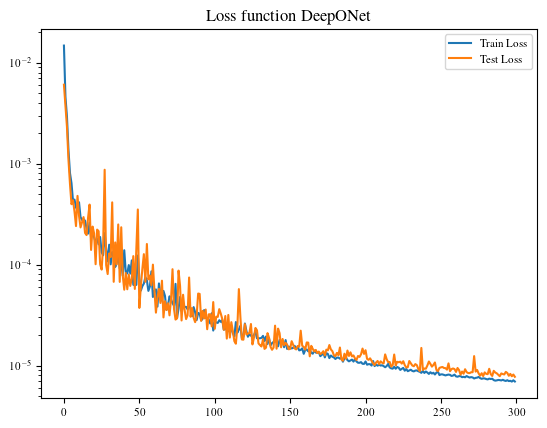

Final Testing Loss: 7.73220752971755e-06
Final Training Loss: 6.944516171013022e-06


<Figure size 640x480 with 0 Axes>

In [328]:
# # Train DeepONet
# deeponet, deeponet_train_loss_arr, deeponet_test_loss_arr = model_trainer(deeponet, trainData, testData, \
#                                                          deeponet_config.epochs, sim_config.batch_size, \
#                                                          deeponet_config.gamma, deeponet_config.learning_rate,\
#                                                          deeponet_config.weight_decay,\
#                                                          "../models/UnicycleTimeVaryingDelayModels/deeponet")
# evaluate_train_performance(deeponet, deeponet_config.model_type, deeponet_train_loss_arr, deeponet_test_loss_arr)

Epoch Time Train Loss Test Loss
Total epochs 300
0 2.6525845527648926 0.03340809545388733 0.009803105419176438
5 2.4656147956848145 0.0015202882297694366 0.0014082364338849271
10 2.4458794593811035 0.0003833191088687374 0.0003584322174512116
15 2.3946475982666016 0.0001538827497080249 0.00016727356659618044
20 2.461609125137329 8.292497325817113e-05 7.062244601131949e-05
25 2.548579454421997 6.152849301522028e-05 4.692512369989085e-05
30 2.3843507766723633 4.737146398314973e-05 6.285945883497508e-05
35 2.4251527786254883 4.312319560672004e-05 4.152744755657974e-05
40 2.3775458335876465 3.602856635016271e-05 4.226590363754122e-05
45 2.487163782119751 3.0442276016840993e-05 3.0190811952389408e-05
50 2.4691708087921143 2.546818306742275e-05 2.3077927012525922e-05
55 2.465923547744751 2.4468446858748846e-05 2.5837258824991757e-05
60 2.5956075191497803 2.145345281167475e-05 1.8008640475431643e-05
65 2.4452908039093018 1.9240113319380916e-05 2.186046114931944e-05
70 2.4351677894592285 1.7920

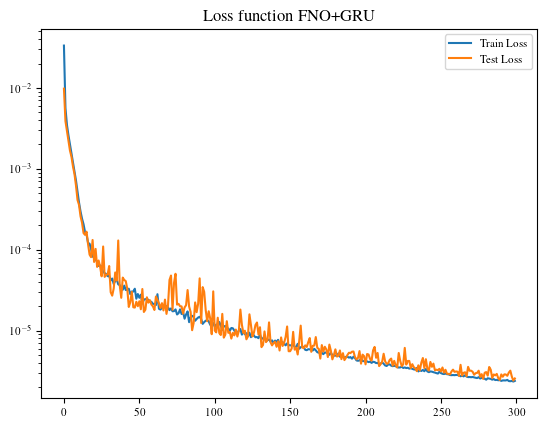

Final Testing Loss: 2.5623547257748126e-06
Final Training Loss: 2.3914559142536053e-06


<Figure size 640x480 with 0 Axes>

In [329]:
# # Train fno_gru
# fno_gru, fno_gru_train_loss_arr, fno_gru_test_loss_arr = model_trainer(fno_gru, trainData, testData, \
#                                                          fno_gru_config.epochs, sim_config.batch_size, \
#                                                          fno_gru_config.gamma, fno_gru_config.learning_rate,\
#                                                          fno_gru_config.weight_decay, \
#                                                          "../models/UnicycleTimeVaryingDelayModels/fnogru")
# evaluate_train_performance(fno_gru, fno_gru_config.model_type, fno_gru_train_loss_arr, fno_gru_test_loss_arr)

Epoch Time Train Loss Test Loss
Total epochs 300
0 1.4574332237243652 0.02018103224091351 0.007647834082562772
5 1.506124496459961 0.0016012741135951085 0.001347434203443487
10 1.5696401596069336 0.0006130103548985805 0.0004708169329364503
15 1.4015123844146729 0.00040849221806305746 0.00039286842238941483
20 1.3969473838806152 0.0003010390657895587 0.00029605703284254386
25 1.4177780151367188 0.0002333255739345796 0.0002096880425741556
30 1.396169662475586 0.00018355988012740495 0.00017243077632479576
35 1.401413917541504 0.00015918883166206029 0.00016738705328732197
40 1.4006710052490234 0.0001330370557474094 0.00014988214296329441
45 1.4219591617584229 0.00011800975417127944 0.0002008561990343936
50 1.4070837497711182 0.00010276798177080405 0.00013189014331031117
55 1.423332929611206 9.376271711458737e-05 9.831088558828e-05
60 1.4091205596923828 9.06548038127416e-05 0.00013498018972948932
65 1.3990793228149414 8.207460995053261e-05 0.00010079237703365155
70 1.4086852073669434 7.1903

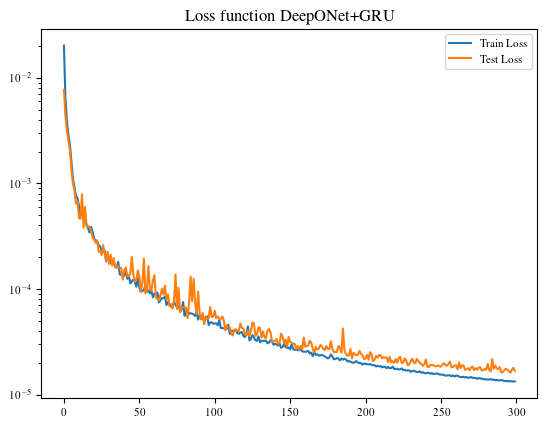

Final Testing Loss: 1.685365076275683e-05
Final Training Loss: 1.3322095756794975e-05


<Figure size 640x480 with 0 Axes>

In [330]:
# # Train deeponet_gru
# deeponet_gru, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr = model_trainer(deeponet_gru, trainData, testData, \
#                                                           deeponet_gru_config.epochs, sim_config.batch_size, \
#                                                           deeponet_gru_config.gamma, deeponet_gru_config.learning_rate,\
#                                                           deeponet_gru_config.weight_decay, \
#                                                            "../models/UnicycleTimeVaryingDelayModels/deeponetgru")
# evaluate_train_performance(deeponet_gru, deeponet_gru_config.model_type, deeponet_gru_train_loss_arr, deeponet_gru_test_loss_arr)

### Load our trained models
Either load the pretrained models on hugging face or the trained models from the previous cells. 

In [194]:
# Load models, note the incompatible keys is due to the NeuralOperator package and torch load. This can be ignored. 

fno.load_state_dict(torch.load("../models/UnicycleTimeVaryingDelayModels/" + fno_config.model_filename, weights_only=False), strict=False)
deeponet.load_state_dict(torch.load("../models/UnicycleTimeVaryingDelayModels/" + deeponet_config.model_filename, weights_only=True))
fno_gru.load_state_dict(torch.load("../models/UnicycleTimeVaryingDelayModels/" + fno_gru_config.model_filename, weights_only=False), strict=False)
deeponet_gru.load_state_dict(torch.load("../models/UnicycleTimeVaryingDelayModels/" + deeponet_gru_config.model_filename, weights_only=True), strict=False)

<All keys matched successfully>

### Evaluate our trained models
This is split into three parts:
 - Evaluate our trained models over the dataset (make sure you load the dataset above first)
 - 25 random trajectories
 - Computational time

In [13]:
fno_train_error, fno_test_error = evaluate_model(fno, fno_config.model_type, trainData, testData)
deeponet_train_error, deeponet_test_error = evaluate_model(deeponet, deeponet_config.model_type, trainData, testData)
fno_gru_train_error, fno_gru_test_error = evaluate_model(fno_gru, fno_gru_config.model_type, trainData, testData)
deeponet_gru_train_error, deeponet_gru_test_error = evaluate_model(deeponet_gru, deeponet_gru_config.model_type, trainData, testData)

In [14]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU"]
train_losses = [fno_train_error, deeponet_train_error, fno_gru_train_error, deeponet_gru_train_error]
test_losses = [fno_test_error, deeponet_test_error, fno_gru_test_error, deeponet_gru_test_error]

# Header
print(f"{'Model':<15} {'Train Loss':<12} {'Test Loss':<10}")
print("-" * 39)

# Rows
for model, train, test in zip(model_names, train_losses, test_losses):
    print(f"{model:<15} {train:<12.7f} {test:<10.7f}")

Model           Train Loss   Test Loss 
---------------------------------------
FNO             0.0000013    0.0000014 
DeepONet        0.0000065    0.0000077 
FNO+GRU         0.0000023    0.0000026 
DeepONet+GRU    0.0000135    0.0000169 


#### Evaluate over 25 trajectories
This may take some time to evaluate. Choose a value < 25 for faster performance. 

In [196]:
def sim_trajectories(num_trajs, init_cond_randomization_variance, delay_randomization_variance, model, predictor_func, sim_config, verbose=True):
    best_stabilization_error = np.inf
    worst_stabilization_error = 0
    best_stabilization_ic = None
    worst_stabilization_ic = None
    best_delay = None
    worst_delay = None
    stabilization_error_arr = []
    np.random.seed(sim_config.random_state)
    for i in range(num_trajs):

        # Controls the initial condition variance
        init_cond = np.array([1, 1, 1]) + np.random.uniform(-init_cond_randomization_variance, init_cond_randomization_variance, size=3)
        # Controls the delay function variance
        b = np.random.uniform(2, 2+delay_randomization_variance, size=1)
        u_delay, control_delay, pde, predictors, delay_vals = simulate_system_non_const_delay(init_cond, \
                    sim_config.dt, sim_config.T, sim_config.dx, [sim_config.phi, sim_config.phi_inv, sim_config.phi_inv_deriv], (sim_config.a, b[0]), predictor_func, model)

        stabilization_error = np.mean(np.linalg.norm(u_delay, axis=1))
        stabilization_error_arr.append(stabilization_error)
        if stabilization_error < best_stabilization_error:
            best_stabilization_ic = init_cond
            best_stabilization_error = stabilization_error
            best_delay = b[0]
        if stabilization_error > worst_stabilization_error:
            worst_stabilization_ic = init_cond
            worst_stabilization_error = stabilization_error
            worst_delay = b[0]
    avg_stabilization_error = np.mean(np.array(stabilization_error_arr))
    return best_stabilization_ic, best_delay, worst_stabilization_ic, worst_delay, avg_stabilization_error

In [197]:
# FNO
best_ic_fno, best_delay_fno, worst_ic_fno, worst_delay_fno, stabilization_error_fno = \
    sim_trajectories(25, 0.1, 0.1, fno, ml_predictor, sim_config, True)

In [198]:
# deeponet
best_ic_deeponet, best_delay_deeponet, worst_ic_deeponet, worst_delay_deeponet, stabilization_error_deeponet = \
    sim_trajectories(25, 0.1, 0.1, deeponet, ml_predictor, sim_config, True)

In [199]:
# fnogru
best_ic_fno_gru, best_delay_fno_gru, worst_ic_fno_gru, worst_delay_fno_gru, stabilization_error_fno_gru = \
    sim_trajectories(25, 0.1, 0.1, fno_gru, ml_predictor, sim_config, True)

In [200]:
# deeponet_gru
best_ic_deeponet_gru, best_delay_deeponet_gru, worst_ic_deeponet_gru, worst_delay_deeponet_gru, stabilization_error_deeponet_gru = \
    sim_trajectories(25, 0.1, 0.1, deeponet_gru, ml_predictor, sim_config, True)

In [201]:
# numerical
_, _, _, _, stabilization_error_numerical = \
    sim_trajectories(25, 0.1, 0.1, None, None, sim_config, True)

In [202]:
model_names = ["FNO", "DeepONet", "FNO+GRU", "DeepONet+GRU", "Numerical"]
stabilization_errors = [stabilization_error_fno, stabilization_error_deeponet, stabilization_error_fno_gru,\
                     stabilization_error_deeponet_gru, stabilization_error_numerical]

# Header
print(f"{'Model':<15} {'Avg. stabilization Error':<20}")
print("-" * 65)

# Rows
for model, error in zip(model_names, stabilization_errors):
    print(f"{model:<15} {error:<20.6f}")

Model           Avg. stabilization Error
-----------------------------------------------------------------
FNO             0.618899            
DeepONet        0.614086            
FNO+GRU         0.637864            
DeepONet+GRU    1.564935            
Numerical       0.612850            


#### FNO Qualatative plots

In [203]:
# Simulate FNO best case example
fno_best_states, fno_best_controls, _, fno_best_predictors, _ = \
simulate_system_non_const_delay(best_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (sim_config.a, best_delay_fno), ml_predictor, fno )
numerical_best_states, numerical_best_controls, _, numerical_best_predictors, _  = \
simulate_system_non_const_delay(best_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (sim_config.a, best_delay_fno))

In [204]:
# Simulate FNO worst case example
fno_worst_states, fno_worst_controls, _, fno_worst_predictors, _ = \
simulate_system_non_const_delay(worst_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (sim_config.a, worst_delay_fno), ml_predictor, fno )
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors, _  = \
simulate_system_non_const_delay(worst_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (sim_config.a, worst_delay_fno))

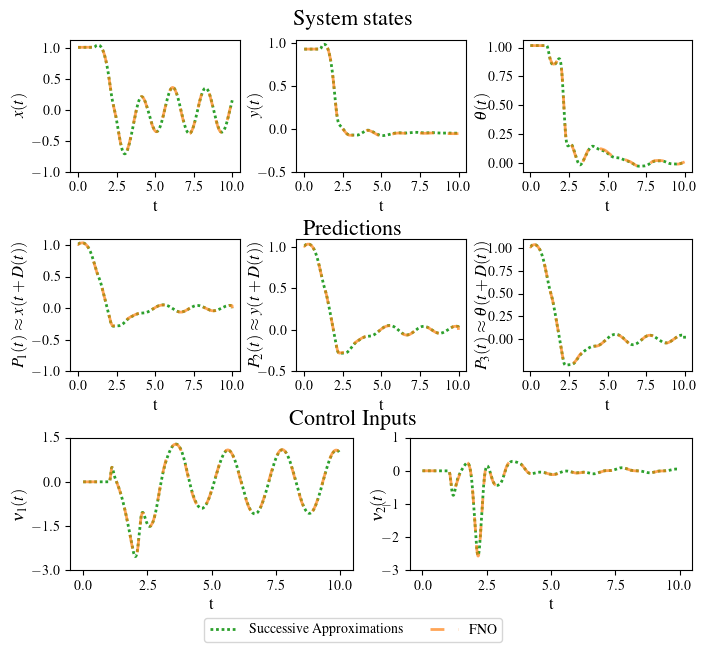

In [207]:
# Plot FNO best Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_best_states,  fno_best_states, \
                            numerical_best_controls, fno_best_controls, numerical_best_predictors,fno_best_predictors, None)

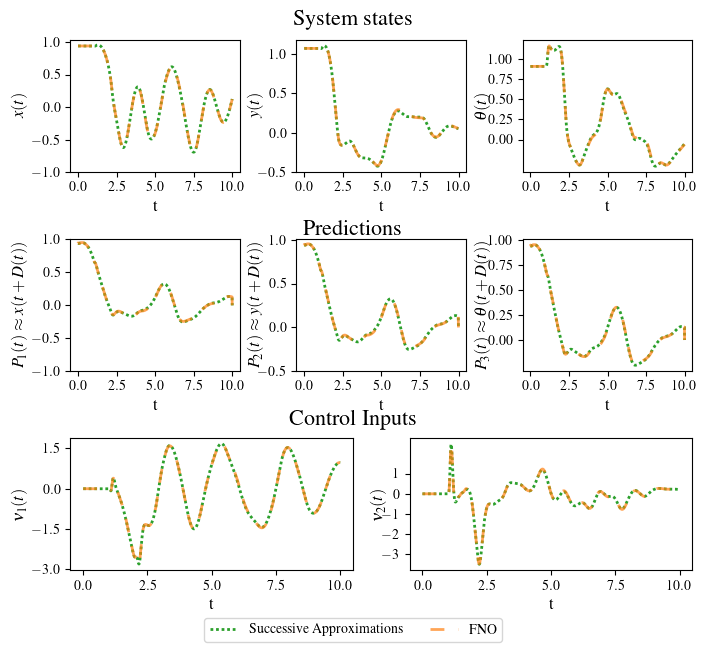

In [206]:
# Plot FNO worst Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_worst_states,  fno_worst_states, \
                            numerical_worst_controls, fno_worst_controls, numerical_worst_predictors,fno_worst_predictors, None)

#### Recreate main figure from paper!

In [254]:
main_ic_fno = np.array([1, 1, 1])
main_delay = 2
new_delay = 10
fno_main_states, fno_main_controls, _, fno_main_predictors, _ = \
simulate_system_non_const_delay(main_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (sim_config.a, main_delay), ml_predictor, fno )

numerical_main_states, numerical_main_controls, _, numerical_main_predictors, _  = \
simulate_system_non_const_delay(main_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (sim_config.a, main_delay))

fno_diff_delay_states, fno_diff_delay_controls, _, fno_diff_delay_predictors, _ = \
simulate_system_non_const_delay(main_ic_fno, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (3, 4), ml_predictor, fno )

In [257]:
phi1 = np.zeros(len(sim_config.t))
phi2 = np.zeros(len(sim_config.t))
for i, val in enumerate(sim_config.t):
    phi1[i] = -1*phi(val, sim_config.a, main_delay) + val
    phi2[i] = -1*phi(val, sim_config.a, new_delay) + val

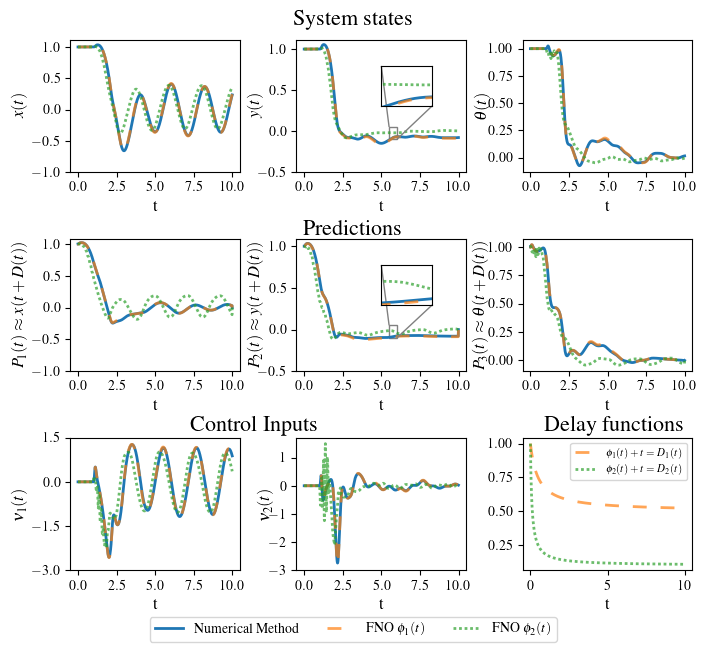

In [263]:
# Use tex fonts for plotting
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)
plot_trajectory_time_varying_extra_delay(sim_config.t, numerical_main_states,  fno_main_states, fno_diff_delay_states, \
                            numerical_main_controls, fno_main_controls, fno_diff_delay_controls, numerical_main_predictors, fno_main_predictors,fno_diff_delay_predictors,phi1, phi2, "timeVarying.pdf")

#### DeepONet Qualatative plots

In [217]:
# Simulate deeponet best case example
deeponet_best_states, deeponet_best_controls, _, deeponet_best_predictors, _ = \
simulate_system_non_const_delay(best_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, best_delay_deeponet), ml_predictor, deeponet )
numerical_best_states, numerical_best_controls, _, numerical_best_predictors, _  = \
simulate_system_non_const_delay(best_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, best_delay_deeponet))

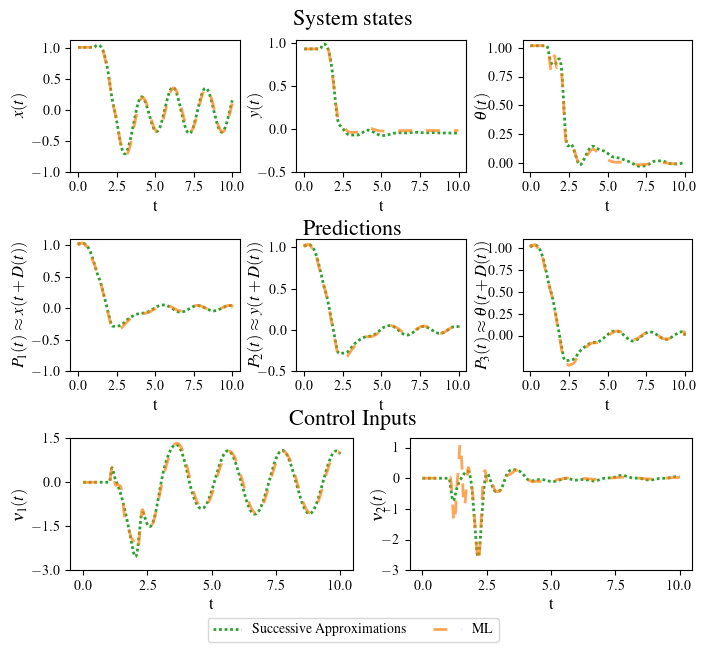

In [218]:
# Plot deeponet best Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_best_states,  deeponet_best_states, \
                            numerical_best_controls, deeponet_best_controls, numerical_best_predictors,deeponet_best_predictors, None)

In [219]:
# Simulate deeponet worst case example
deeponet_worst_states, deeponet_worst_controls, _, deeponet_worst_predictors, _ = \
simulate_system_non_const_delay(worst_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, worst_delay_deeponet), ml_predictor, deeponet )
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors, _  = \
simulate_system_non_const_delay(worst_ic_deeponet, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, worst_delay_deeponet))

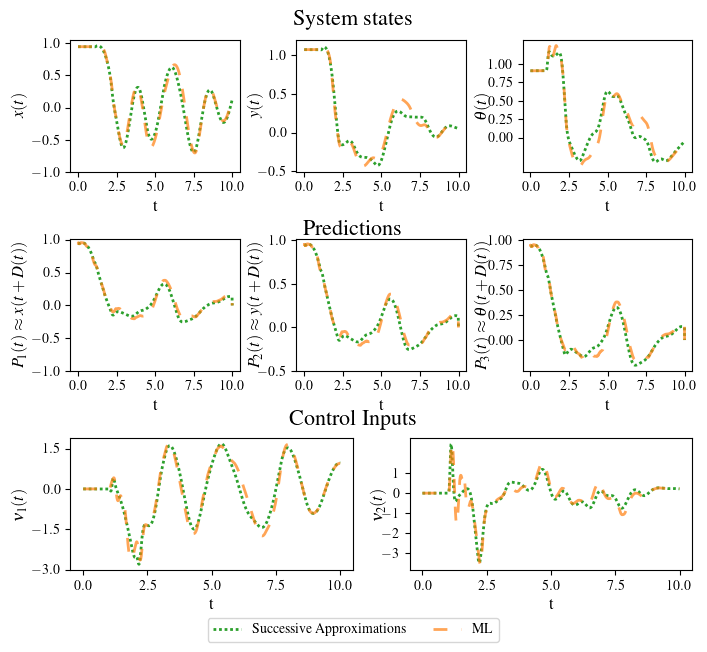

In [220]:
# Plot deeponet worst Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_worst_states,  deeponet_worst_states, \
                            numerical_worst_controls, deeponet_worst_controls, numerical_worst_predictors,deeponet_worst_predictors, None)

#### FNO+GRU Qualatative plots

In [221]:
# Simulate fno_gru best case example
fno_gru_best_states, fno_gru_best_controls, _, fno_gru_best_predictors, _ = \
simulate_system_non_const_delay(best_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, best_delay_fno_gru), ml_predictor, fno_gru )
numerical_best_states, numerical_best_controls, _, numerical_best_predictors, _  = \
simulate_system_non_const_delay(best_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, best_delay_fno_gru))

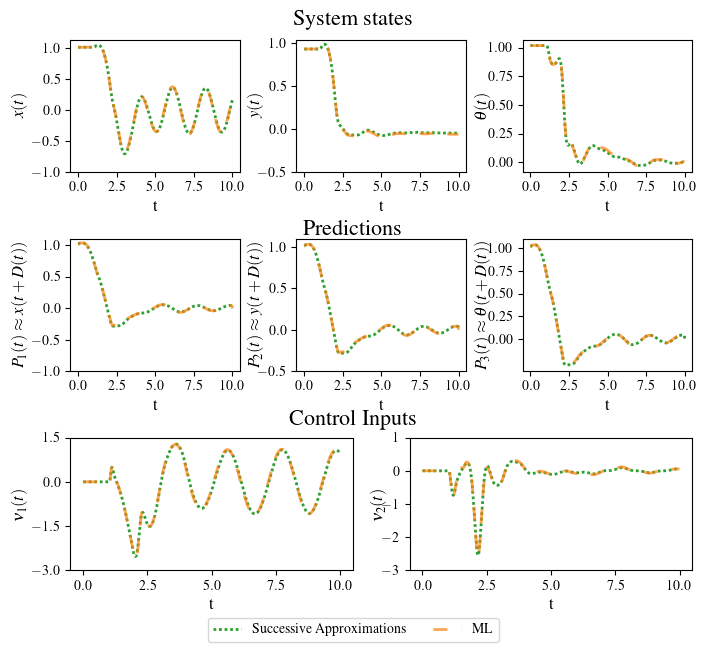

In [222]:
# Plot fno_gru best Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_best_states,  fno_gru_best_states, \
                            numerical_best_controls, fno_gru_best_controls, numerical_best_predictors,fno_gru_best_predictors, None)

In [223]:
# Simulate fno_gru worst case example
fno_gru_worst_states, fno_gru_worst_controls, _, fno_gru_worst_predictors, _ = \
simulate_system_non_const_delay(worst_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, worst_delay_fno_gru), ml_predictor, fno_gru )
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors, _  = \
simulate_system_non_const_delay(worst_ic_fno_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, worst_delay_fno_gru))

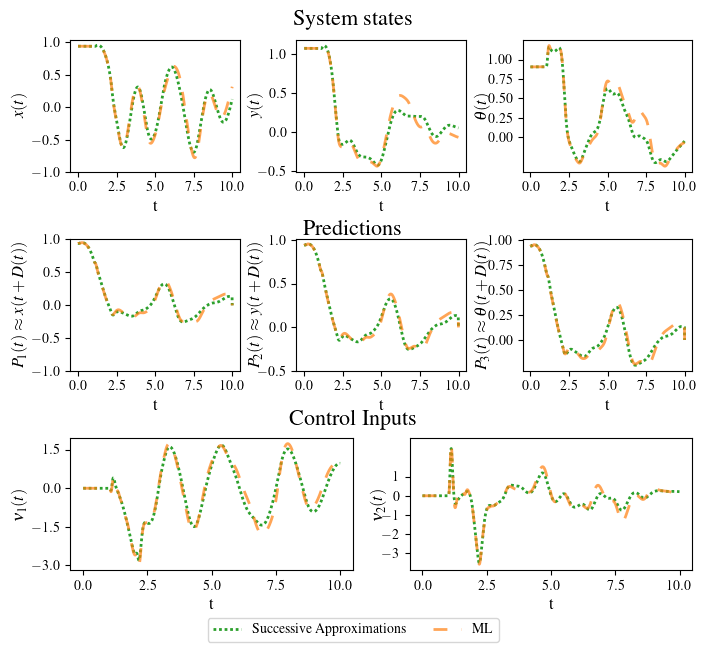

In [224]:
# Plot fno_gru worst Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_worst_states,  fno_gru_worst_states, \
                            numerical_worst_controls, fno_gru_worst_controls, numerical_worst_predictors,fno_gru_worst_predictors, None)

#### DeepONet+GRU Qualatative plots

In [225]:
# Simulate deeponet_gru best case example
deeponet_gru_best_states, deeponet_gru_best_controls, _, deeponet_gru_best_predictors, _ = \
simulate_system_non_const_delay(best_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, best_delay_deeponet_gru), ml_predictor, deeponet_gru )
numerical_best_states, numerical_best_controls, _, numerical_best_predictors, _  = \
simulate_system_non_const_delay(best_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, best_delay_deeponet_gru))

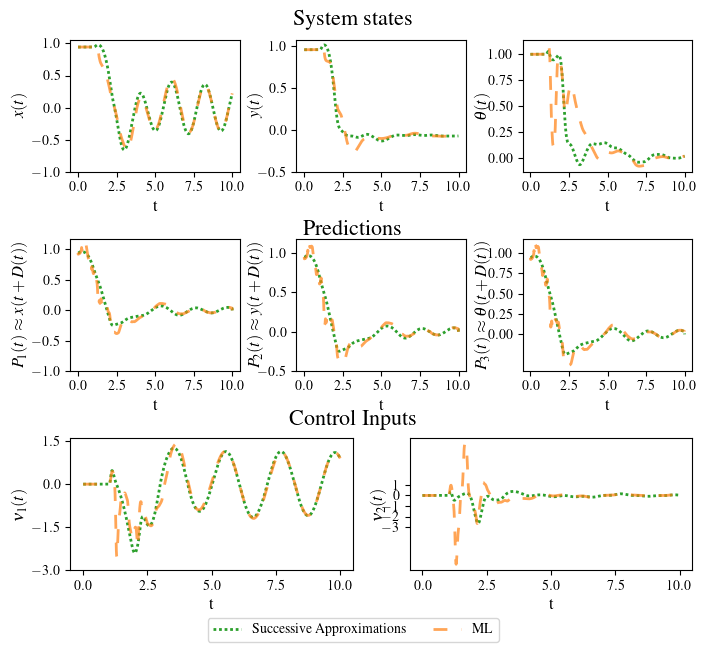

In [226]:
# Plot deeponet_gru best Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_best_states,  deeponet_gru_best_states, \
                            numerical_best_controls, deeponet_gru_best_controls, numerical_best_predictors,deeponet_gru_best_predictors, None)

In [227]:
# Simulate deeponet_gru worst case example
deeponet_gru_worst_states, deeponet_gru_worst_controls, _, deeponet_gru_worst_predictors, _ = \
simulate_system_non_const_delay(worst_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, worst_delay_deeponet_gru), ml_predictor, deeponet_gru )
numerical_worst_states, numerical_worst_controls, _, numerical_worst_predictors, _  = \
simulate_system_non_const_delay(worst_ic_deeponet_gru, sim_config.dt, sim_config.T, sim_config.dx, [phi, phi_inv, phi_inv_deriv], (a, worst_delay_deeponet_gru))

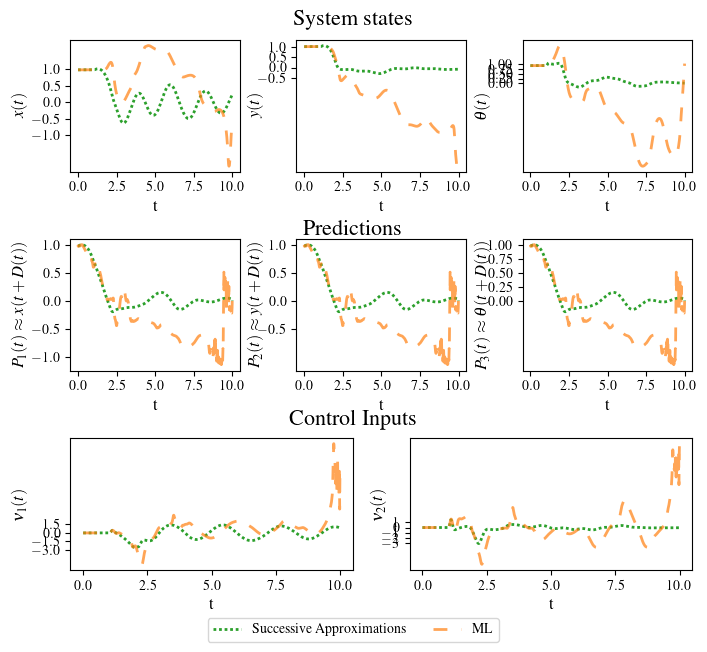

In [228]:
# Plot deeponet_gru worst Trajectory
plot_trajectory_time_varying(sim_config.t, numerical_worst_states,  deeponet_gru_worst_states, \
                            numerical_worst_controls, deeponet_gru_worst_controls, numerical_worst_predictors,deeponet_gru_worst_predictors, None)

### Comparion of computation time for various discretizations 

In [45]:
names = ["numerical", "fno", "deeponet", "fnogru", "deeponetgru"]
time_steps = [0.01, 0.005, 0.001, 0.0005]
predictor_trials = 1000

numerical_times = np.zeros(len(time_steps))
deeponet_times = np.zeros(len(time_steps))
fno_times = np.zeros(len(time_steps))
deeponet_gru_times = np.zeros(len(time_steps))
deeponet_gru_times = np.zeros(len(time_steps))

In [46]:
for i, dx in enumerate(time_steps):
    x = np.arange(0, 1, dx)
    nx = len(x)
    state = np.random.uniform(0, 1, size=3)
    control_history = np.random.uniform(0, 1, size=(nx, 2))
    D = 1

    # FNO - Use above config. 
    fno = FNOProjected(fno_config.hidden_size, fno_config.num_layers, fno_config.modes, fno_config.input_channel, fno_config.output_channel)

    # DeepONET - Need to update dt
    deeponet_grid = np.arange(0, sim_config.D, dx/6).astype(np.float32)
    deeponet_grid = torch.from_numpy(deeponet_grid.reshape((len(deeponet_grid), 1))).to(sim_config.device)
    deeponet_config.update_config(input_channel=deeponet_grid.shape[0], output_channel=nx*3)
    deeponet = DeepONetProjected(deeponet_config.dim_x, deeponet_config.hidden_size, deeponet_config.num_layers, \
                                deeponet_config.input_channel, deeponet_config.output_channel, \
                                deeponet_grid)

    # FNO+GRU - Use above config. 
    fno_gru_config.update_config(input_channel=6, output_channel=3)
    fno_gru = FNOGRUNet(fno_gru_config.fno_num_layers, fno_gru_config.gru_num_layers, fno_gru_config.fno_hidden_size, \
              fno_gru_config.gru_hidden_size, fno_gru_config.modes, fno_gru_config.input_channel, \
              fno_gru_config.output_channel)

    # DeepONET+GRU - Need to update dt
    deeponet_gru_grid = np.arange(0, sim_config.D, dx/6).astype(np.float32)
    deeponet_gru_grid = torch.from_numpy(deeponet_gru_grid.reshape((len(deeponet_gru_grid), 1))).to(sim_config.device)
    deeponet_gru_config.update_config(input_channel=deeponet_gru_grid.shape[0], output_channel=nx*3)
    deeponet_gru = DeepONetGRUNet(deeponet_gru_config.dim_x, deeponet_gru_config.deeponet_num_layers, deeponet_gru_config.gru_num_layers, \
                             deeponet_gru_config.deeponet_hidden_size, deeponet_gru_config.gru_hidden_size, deeponet_gru_config.input_channel, \
                             deeponet_gru_config.output_channel, deeponet_gru_grid)

    # Numerical Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        predictor_non_const_delay(state, control_history, D, x)
    end_time = time.time()
    numerical_times[i] = (end_time-start_time)/predictor_trials*1000

    # FNO Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, fno)
    end_time = time.time()
    fno_times[i] = (end_time-start_time)/predictor_trials*1000

    # DeepONet Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, deeponet)
    end_time = time.time()
    deeponet_times[i] = (end_time-start_time)/predictor_trials*1000

    
    # FNO+GRU Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, fno_gru)
    end_time = time.time()
    fno_gru_times[i] = (end_time-start_time)/predictor_trials*1000

    # DeepONet+GRU Predictor
    start_time = time.time()
    for k in range(predictor_trials):
        ml_predictor(state, control_history, D, x, deeponet_gru)
    end_time = time.time()
    deeponet_gru_times[i] = (end_time-start_time)/predictor_trials*1000
 

In [47]:
# Combine data into list of rows
rows = [
    ("Numerical", numerical_times),
    ("FNO", fno_times),
    ("DeepONet", deeponet_times),
    ("FNO-GRU", fno_gru_times),
    ("DeepONet-GRU", deeponet_gru_times)
]

# Print header
print("RAW CALCULATION TIMES (ms)")

header = f"{'Step size':>15}" + "".join([f"{ts:>12.4f}" for ts in time_steps])
print(header)
print("-" * len(header))

# Print each row
for name, values in rows:
    print(f"{name:>15}" + "".join([f"{v:12.4f}" for v in values]))

RAW CALCULATION TIMES (ms)
      Step size      0.0100      0.0050      0.0010      0.0005
---------------------------------------------------------------
      Numerical      1.9616      3.9585     21.5719     45.5195
            FNO      0.9903      0.9871      1.0181      1.0102
       DeepONet      0.2706      0.2704      1.1535      3.9059
        FNO-GRU      1.1782      1.2531      1.8020      2.4899
   DeepONet-GRU      0.5096      0.5793      1.8875      5.2711


In [48]:
# Combine data into list of rows
rows = [
    ("FNO", fno_times),
    ("DeepONet", deeponet_times),
    ("FNO-GRU", fno_gru_times),
    ("DeepONet-GRU", deeponet_gru_times)
]

# Print header
print("Speedup (numerical/ML_model)")

header = f"{'Step size':>15}" + "".join([f"{ts:>12.4f}" for ts in time_steps])
print(header)
print("-" * len(header))

# Print each row
for name, model_vals in rows:
    row = f"{name:>15}"
    for idx, val in enumerate(model_vals):
        num_time = numerical_times[idx]
        speedup = num_time / val if val != 0 else float('inf')
        row += f"{speedup:12.4f}"
    print(row)

Speedup (numerical/ML_model)
      Step size      0.0100      0.0050      0.0010      0.0005
---------------------------------------------------------------
            FNO      1.9808      4.0101     21.1877     45.0605
       DeepONet      7.2500     14.6410     18.7014     11.6539
        FNO-GRU      1.6649      3.1591     11.9713     18.2816
   DeepONet-GRU      3.8491      6.8329     11.4288      8.6357
